# Построение графа из транзакций

Главная идея:

Каждая строка = одна вершина (узел, node) графа

Рёбра (связи) между узлами добавляются по какому-то смысловому принципу (например: общий номер карты, имейл, адрес, device и т.п.)

Пример: Связываем все транзакции с одинаковой card1

In [1]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class SimpleGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x.squeeze()

In [2]:
class GCNWithLinear(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.lin = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.lin(x)
        return x.squeeze()

In [24]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class ImprovedGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.lin = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.lin(x)    # линейный выход — хорошо для бинарной задачи (BCEWithLogitsLoss)
        return x.squeeze()

In [3]:
import torch
from torch import nn
from torch_geometric.loader import NeighborLoader

def train(
    model, 
    loader: NeighborLoader, 
    criterion=None, 
    optimizer=None, 
    scheduler=None, 
    epochs=100, 
    device="cpu", 
    grad_clip=None,
    verbose=True):

    model.to(device)
    model.train()

    # если не передан criterion - задаём BCEWithLogitsLoss
    if criterion is None:
        criterion = nn.BCEWithLogitsLoss()
    # если не передан оптимизатор - задаём AdamW + weight_decay
    if optimizer is None:
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=5e-4)
    # Можно добавить ReduceLROnPlateau или StepLR
    if scheduler is None:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

    for epoch in range(epochs):
        epoch_loss = 0
        total = 0
        for batch in loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            logits = model(batch.x, batch.edge_index)
            loss = criterion(logits[:batch.batch_size], batch.y[:batch.batch_size].float())
            loss.backward()
            if grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()
            batch_size = batch.batch_size
            epoch_loss += loss.item() * batch_size  # Даём вес по числу батч
            total += batch_size

        avg_loss = epoch_loss / total if total > 0 else 0
        scheduler.step(avg_loss)
        if verbose:
            print(f"Epoch {epoch+1:03d}/{epochs}, Avg Loss: {avg_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.5f}")

In [4]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

# 📊 Тест
@torch.no_grad()
def evaluate(model, loader: NeighborLoader, name="Model"):
    model.eval()

    all_true = []
    all_probs = []
    all_preds = []
    for batch in loader:
        # Если используешь device:
        # batch = batch.to(device)
        logits = model(batch.x, batch.edge_index)
        # Только для центрального батча:
        logits = logits[:batch.batch_size]
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long()
        true = batch.y[:batch.batch_size].long()
        all_true.append(true.cpu())
        all_probs.append(probs.cpu())
        all_preds.append(preds.cpu())

    all_true = torch.cat(all_true).numpy()
    all_probs = torch.cat(all_probs).numpy()
    all_preds = torch.cat(all_preds).numpy()


    # 🎯 ROC AUC
    fpr, tpr, _ = roc_curve(all_true, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # 🎯 PR AUC
    precision, recall, _ = precision_recall_curve(all_true, all_probs)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, label=f"{name} (PR AUC = {pr_auc:.2f})")
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()

    return {
        "Accuracy": accuracy_score(all_true, all_preds),
        "F1": f1_score(all_true, all_preds),
        "AUC": roc_auc_score(all_true, all_probs),
        "Precision": precision_score(all_true, all_preds),
        "Recall": recall_score(all_true, all_preds)
    }

визуальное представление, как выглядит твой граф:

---

### 1. **Таблица-транзакции (df):**

| index | card1 | card2 | P_emaildomain | ...другие признаки... |
|-------|-------|-------|----------------|----------------------|
|  0    | 12345 | 111   | gmail.com      | ...                  |
|  1    | 12345 | 322   | gmail.com      | ...                  |
|  2    | 67890 | 111   | yahoo.com      | ...                  |
|  3    | 67890 | 111   | gmail.com      | ...                  |

---

### 2. **Вершины графа:**  
_Это каждая строка таблицы (т.е. транзакция)_

```
(0)      (1)      (2)      (3)
 o--------o--------o--------o
```
(на самом деле не в линию, просто для иллюстрации; больше овалов/кружочков — больше транзакций)

---

### 3. **Рёбра = Связи на основе похожих признаков**

- Если card1 одинаковый: соединяем
- Если card2 одинаковый: соединяем
- Если P_emaildomain одинаковый: соединяем
- ...и т.д.

**Пример:**
- (0) и (1) — обе card1=12345 → ребро между 0 и 1
- (0) и (1) — обе gmail.com → ещё одно ребро между 0 и 1 (но в графе “простом” всё равно просто связь)
- (2) и (3) — обе card1=67890 и card2=111 → ребро между 2 и 3 и еще по другому признаку
- (0) и (3) — обе gmail.com → ребро между 0 и 3

---

### 4. **Графически:**

```
(0)———(1)
 |    / 
 |   /   
 |  /
(3)   (2)
  \   /
   \ /
  (2)
```

- (0)-(1): общая card1, общая почта
- (0)-(3): общая почта
- (1)-(3): общая почта
- (2)-(3): общая card1 и card2

> (Это очень упрощённая схема — на практике rib больше и граф гуще.)

---

### 5. **Узлы и признаки**

Каждая вершина (транзакция) содержит свой вектор признаков в `x`.

---

### 6. **Рёбра в PyTorch Geometric**

`edge_index` — для каждой пары, которую ты сформировал по совпадению одного из признаков,  
_например:_
```
edge_index = [[ 0, 0, 2, 3, 3, ...],
              [ 1, 3, 3, 0, 2, ...]] 
# то есть (0->1), (0->3), (2->3), (3->0), (3->2) и т.д.
```

---

## **Визуально (простая схема)**

```
      (0)
     /  \
    /    \
  (1)   (3)
          \
           \
           (2)
```
- 0 и 1 соединены (одинаковая card1, email)
- 0 и 3 соединены (одинаковая email)
- 1 и 3 соединены (одинаковая email)
- 2 и 3 соединены (card1, card2)

---

### **Вывод:**
- **Вершина = транзакция**
- **Ребро = пара транзакций с совпавшим каким-то из важных признаков**

---

**Код оттрисовки части графа:**

```python
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
G.add_edges_from(edge_list[:300])  # ограничь количество рёбер для визуализации
nx.draw(G, with_labels=True, node_size=100)
plt.show()
```

---

In [5]:
import random
import numpy as np
import torch

seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [6]:
import pandas as pd
df = pd.read_csv('../data/processing/df_preprocessing.csv') # Твой датасет
df = df.sort_values('TransactionDT').reset_index(drop=True)

print(df.columns.tolist())

['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D4', 'D10', 'D15', 'M6', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', '

In [7]:
import random

MAX_GROUP_SIZE = 300
PAIR_PER_NODE = 5  # для больших групп: сколько случайных рёбер для каждой ноды

edge_list = []

for col in ['card1', 'card2', 'card3', 'Relative_TransactionDT',  'log_TransactionAmt', 'P_emaildomain']:
    groups = df.groupby(col)
    for val, group in groups:
        if pd.isnull(val): continue
        tx_ids = group.index.tolist()
        n = len(tx_ids)
        if n < 2:
            continue
        if n > MAX_GROUP_SIZE:
            # Сэмплируем пары
            for idx in tx_ids:
                sampled = random.sample(tx_ids, PAIR_PER_NODE)
                for s in sampled:
                    if idx != s:
                        edge_list.append((idx, s))
                        edge_list.append((s, idx))
        else:
            # Все-все пары
            for i in range(n):
                for j in range(i+1, n):
                    edge_list.append((tx_ids[i], tx_ids[j]))
                    edge_list.append((tx_ids[j], tx_ids[i]))
print(f'Рёбер всего: {len(edge_list)}')

Рёбер всего: 44727168


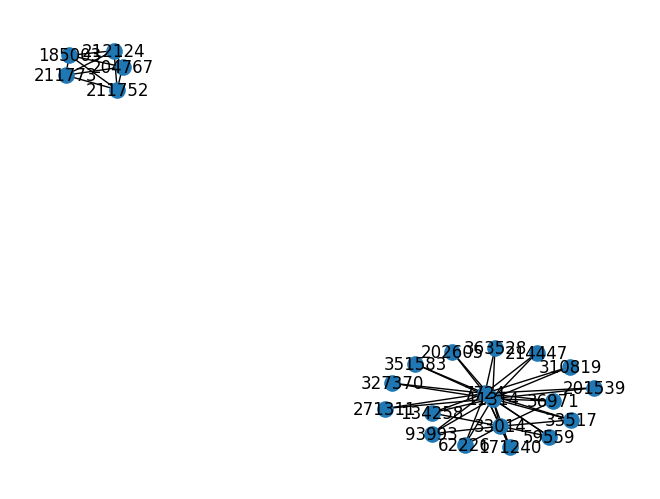

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
G.add_edges_from(edge_list[:100])
nx.draw(G, with_labels=True, node_size=120)
plt.show()

In [9]:
import torch
from torch_geometric.data import Data


feature_cols = [
    
    'card4', 'card5', 'card6', 'addr1', 'addr2', 'ProductCD',
    'Transaction_day', 'Transaction_hour',
    'Transaction_weekday',  'TransactionAmt_binned',
    'isOutlier',
    'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D4', 'D10', 'D15', 'M6', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V279', 'V280', 'V281', 'V282', 'V283', 'V284', 'V285', 'V286', 'V287', 'V288', 'V289', 'V290', 'V291', 'V292', 'V293', 'V294', 'V295', 'V296', 'V297', 'V298', 'V299', 'V300', 'V301', 'V302', 'V303', 'V304', 'V305', 'V306', 'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321'
]
x = torch.tensor(df[feature_cols].values, dtype=torch.float)    # X — матрица признаков (np.array/pd.DataFrame.values) [num_nodes, num_features]
y = torch.tensor(df['isFraud'].values, dtype=torch.long)  # [num_nodes]

# Преобразуеv список рёбер (edge_list) в тензор PyTorch
edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()

data = Data(x=x, edge_index=edge_index, y=y)
data

Data(x=[395677, 199], edge_index=[2, 44727168], y=[395677])

In [10]:
from torch_geometric.loader import NeighborLoader

#device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cpu")
#data = data.to(device)

N_positive = (y == 1).sum().item()
N_negative = (y == 0).sum().item()
pos_weight = torch.tensor([N_negative / N_positive], dtype=torch.float).to(device)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)


# Пусть у тебя граф data как выше

batch_size = 512  # Сколько узлов (транзакций) в одном батче
num_neighbors = [10, 5]  # Сколько соседей собирать на 1-м и 2-м слоях

train_loader = NeighborLoader(
    data,
    num_neighbors=num_neighbors,
    batch_size=batch_size,
    shuffle=False,  # в обучении должен быть shuffle
)



In [11]:
model_simple_gnn = SimpleGNN(input_dim=data.x.shape[1], hidden_dim=32).to(device)

train(model=model_simple_gnn, loader=train_loader, criterion=criterion, epochs=5)

Epoch 001/5, Avg Loss: 9.8734, LR: 0.00100
Epoch 002/5, Avg Loss: 6.6804, LR: 0.00100
Epoch 003/5, Avg Loss: 6.2776, LR: 0.00100
Epoch 004/5, Avg Loss: 6.4301, LR: 0.00100
Epoch 005/5, Avg Loss: 5.1975, LR: 0.00100


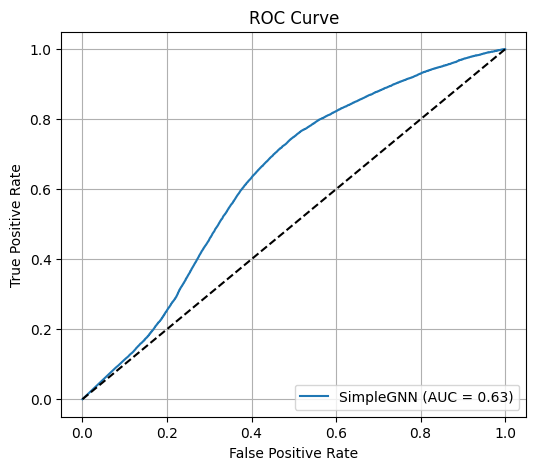

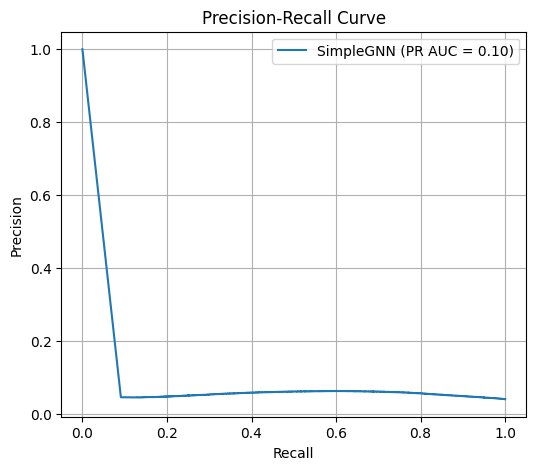

{'Accuracy': 0.6408686883493354,
 'F1': 0.11255167934449982,
 'AUC': np.float64(0.6318985793380304),
 'Precision': 0.06253600105487428,
 'Recall': 0.5621685694678396}

In [12]:
evaluate(model=model_simple_gnn, loader=train_loader, name="SimpleGNN")

In [13]:
model_linear_gnn = GCNWithLinear(input_dim=data.x.shape[1], hidden_dim=32).to(device)

train(model=model_linear_gnn, loader=train_loader, criterion=criterion, epochs=5)

Epoch 001/5, Avg Loss: 2.8597, LR: 0.00100
Epoch 002/5, Avg Loss: 1.4079, LR: 0.00100
Epoch 003/5, Avg Loss: 1.2580, LR: 0.00100
Epoch 004/5, Avg Loss: 1.2154, LR: 0.00100
Epoch 005/5, Avg Loss: 1.1746, LR: 0.00100


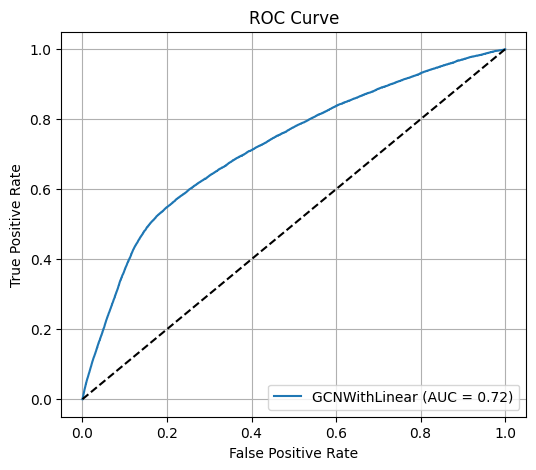

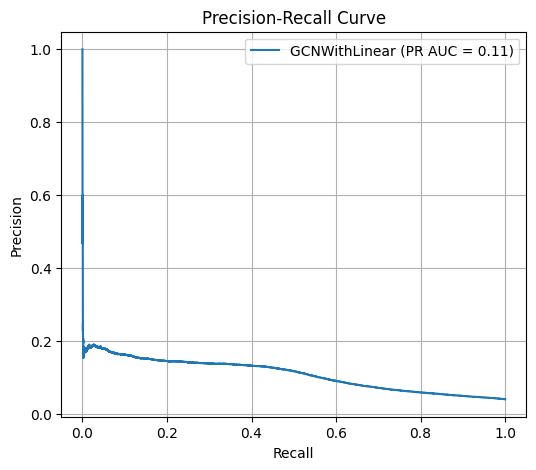

{'Accuracy': 0.6876239963404495,
 'F1': 0.14365291615281223,
 'AUC': np.float64(0.7208531667116584),
 'Precision': 0.08079965706714469,
 'Recall': 0.646765238006114}

In [14]:
evaluate(model=model_linear_gnn, loader=train_loader, name="GCNWithLinear")

In [15]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score

def train_one_epoch(model, loader, criterion, optimizer, device='cpu', grad_clip=None):
    model.train()
    total_loss = 0
    total = 0
    all_preds = []
    all_targets = []
    sigmoid = torch.nn.Sigmoid()

    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        logits = model(batch.x, batch.edge_index)
        y_true = batch.y[:batch.batch_size].float()
        y_pred = logits[:batch.batch_size]
        loss = criterion(y_pred, y_true)
        loss.backward()
        if grad_clip is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        batch_size = batch.batch_size
        total_loss += loss.item() * batch_size
        total += batch_size
        with torch.no_grad():
            all_preds.append(sigmoid(y_pred).cpu())
            all_targets.append(y_true.cpu())
    
    avg_loss = total_loss / total
    preds = torch.cat(all_preds).numpy()
    targets = torch.cat(all_targets).numpy()
    bin_preds = (preds >= 0.5).astype(np.float32)
    acc = accuracy_score(targets, bin_preds)
    try:
        auc = roc_auc_score(targets, preds)
    except:
        auc = np.nan
    return avg_loss, acc, auc

In [16]:
@torch.no_grad()
def validate_one_epoch(model, loader, criterion, device='cpu'):
    model.eval()
    total_loss = 0
    total = 0
    all_preds = []
    all_targets = []
    sigmoid = torch.nn.Sigmoid()

    for batch in loader:
        batch = batch.to(device)
        logits = model(batch.x, batch.edge_index)
        y_true = batch.y[:batch.batch_size].float()
        y_pred = logits[:batch.batch_size]
        loss = criterion(y_pred, y_true)
        batch_size = batch.batch_size
        total_loss += loss.item() * batch_size
        total += batch_size
        all_preds.append(sigmoid(y_pred).cpu())
        all_targets.append(y_true.cpu())
    
    avg_loss = total_loss / total
    preds = torch.cat(all_preds).numpy()
    targets = torch.cat(all_targets).numpy()
    bin_preds = (preds >= 0.5).astype(np.float32)
    acc = accuracy_score(targets, bin_preds)
    try:
        auc = roc_auc_score(targets, preds)
    except:
        auc = np.nan
    return avg_loss, acc, auc

In [19]:
def fit_gnn(
    model,
    train_loader,
    val_loader,
    criterion=None,
    optimizer=None,
    scheduler=None,
    epochs=100,
    device='cpu',
    grad_clip=None,
    early_stopping_rounds=10,
    verbose=True
):
    if criterion is None:
        criterion = torch.nn.BCEWithLogitsLoss()
    if optimizer is None:
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=5e-4)
    if scheduler is None:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

    model.to(device)
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [],
               'train_auc': [], 'val_auc': []}
    best_val_loss = float('inf')
    patience = 0
    best_state = None

    for epoch in range(epochs):
        train_loss, train_acc, train_auc = train_one_epoch(
            model, train_loader, criterion, optimizer, device, grad_clip)
        val_loss, val_acc, val_auc = validate_one_epoch(
            model, val_loader, criterion, device)
        if scheduler is not None:
            scheduler.step(val_loss)

        # logging
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_auc'].append(train_auc)
        history['val_auc'].append(val_auc)

        if verbose:
            print(
                f"Epoch {epoch+1:03d}/{epochs} | "
                f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} | "
                f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f} | "
                f"Train AUC: {train_auc:.4f}, Val AUC: {val_auc:.4f} | "
                f"LR: {optimizer.param_groups[0]['lr']:.5f}"
            )

        # early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model.state_dict()
            patience = 0
        else:
            patience += 1
            if patience >= early_stopping_rounds:
                if verbose:
                    print(f'Early stopping at epoch {epoch+1}, best val loss: {best_val_loss:.4f}')
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model, history

In [25]:
#device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cpu")
#data = data.to(device)

N_positive = (y == 1).sum().item()
N_negative = (y == 0).sum().item()
pos_weight = torch.tensor([N_negative / N_positive], dtype=torch.float).to(device)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

model = ImprovedGNN(input_dim=data.x.shape[1], hidden_dim=32).to(device)

model, history = fit_gnn(
    model, 
    train_loader, 
    train_loader, 
    epochs=5,
    device="cpu",
    grad_clip=2.0,
    early_stopping_rounds=10,
    criterion=criterion,
)

Epoch 001/5 | Train Loss: 1.2175, Val Loss: 1.1880 | Train Acc: 0.7723, Val Acc: 0.7497 | Train AUC: 0.7029, Val AUC: 0.7147 | LR: 0.00100
Epoch 002/5 | Train Loss: 1.1923, Val Loss: 1.1883 | Train Acc: 0.7490, Val Acc: 0.7548 | Train AUC: 0.7177, Val AUC: 0.7171 | LR: 0.00100
Epoch 003/5 | Train Loss: 1.1892, Val Loss: 1.1847 | Train Acc: 0.7469, Val Acc: 0.7310 | Train AUC: 0.7184, Val AUC: 0.7202 | LR: 0.00100
Epoch 004/5 | Train Loss: 1.1869, Val Loss: 1.1851 | Train Acc: 0.7441, Val Acc: 0.7288 | Train AUC: 0.7181, Val AUC: 0.7214 | LR: 0.00100
Epoch 005/5 | Train Loss: 1.1836, Val Loss: 1.1774 | Train Acc: 0.7531, Val Acc: 0.7310 | Train AUC: 0.7207, Val AUC: 0.7253 | LR: 0.00100


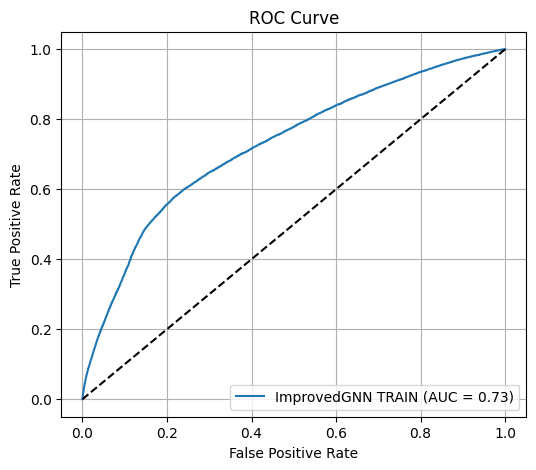

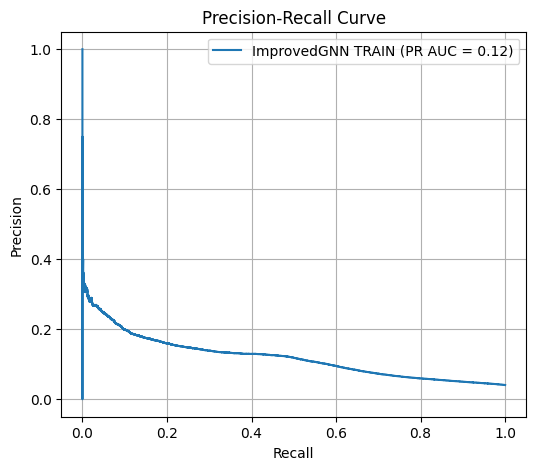

{'Accuracy': 0.7309724851330757,
 'F1': 0.15708787989167444,
 'AUC': np.float64(0.7250557434249104),
 'Precision': 0.08996254206082153,
 'Recall': 0.6188158961881589}

In [26]:
evaluate(model=model, loader=train_loader, name="ImprovedGNN TRAIN")

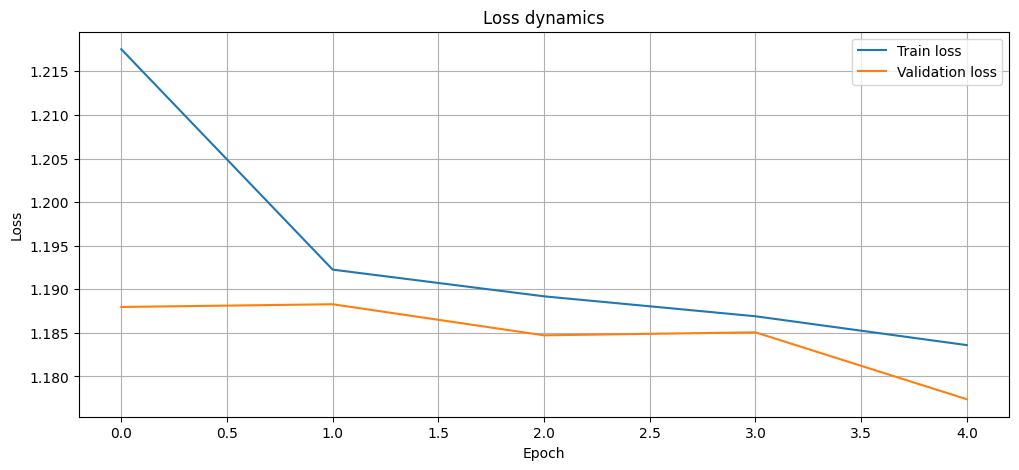

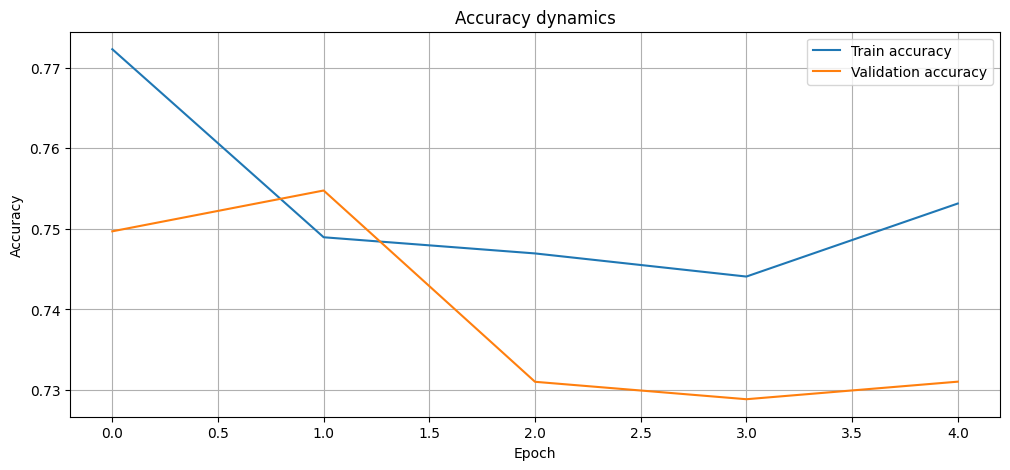

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(history['train_loss'], label='Train loss')
plt.plot(history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.title('Loss dynamics')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(history['train_acc'], label='Train accuracy')
plt.plot(history['val_acc'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy dynamics')
plt.show()

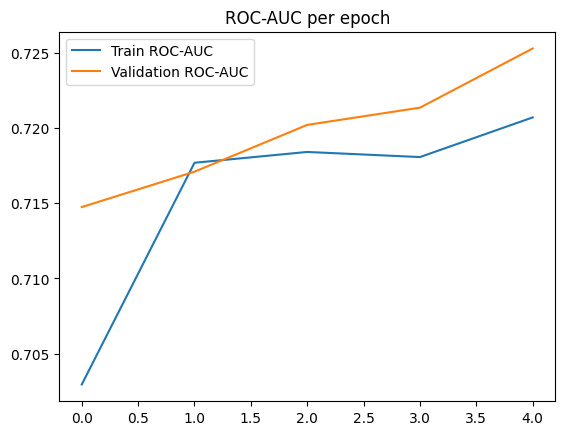

In [28]:
plt.plot(history['train_auc'], label='Train ROC-AUC')
plt.plot(history['val_auc'], label='Validation ROC-AUC')
plt.legend()
plt.title("ROC-AUC per epoch")
plt.show()

## Refactored code

In [43]:
# === 7. ВИЗУАЛИЗАЦИЯ ЛОССОВ и МЕТРИК ===
import matplotlib.pyplot as plt
import numpy as np

# Функция для рисования метрик из логов обучения
def plot_training_history(history, title_prefix=""):
    n_epoch = len(history['train_loss'])
    x = np.arange(1, n_epoch+1)
    plt.figure(figsize=(15,4))
    
    plt.subplot(1,3,1)
    plt.plot(x, history['train_loss'], label='Train Loss')
    plt.plot(x, history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{title_prefix}Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1,3,2)
    plt.plot(x, history['train_acc'], label='Train Acc')
    plt.plot(x, history['val_acc'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{title_prefix}Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1,3,3)
    plt.plot(x, history['train_auc'], label='Train AUC')
    plt.plot(x, history['val_auc'], label='Val AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.title(f'{title_prefix}AUC')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [44]:
# === 3. Обучение и валидация на одну эпоху ===

from sklearn.metrics import roc_auc_score, accuracy_score

def train_one_epoch(model, loader, criterion, optimizer, device, grad_clip=None):
    model.train()
    losses = []
    y_true = []
    y_pred = []
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        # batch.y: для задачи node или graph classification — меняйте по ситуации
        loss = criterion(out, batch.y.squeeze().float())
        loss.backward()
        if grad_clip is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        losses.append(loss.item())
        y_true.append(batch.y.cpu().numpy())
        y_pred.append(torch.sigmoid(out).detach().cpu().numpy())
    # Flatten
    import numpy as np
    y_true = np.concatenate(y_true).ravel()
    y_pred = np.concatenate(y_pred).ravel()
    # Accuracy & AUC
    acc = (np.round(y_pred) == y_true).mean()
    try:
        auc = roc_auc_score(y_true, y_pred)
    except:
        auc = 0.0
    return np.mean(losses), acc, auc

def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    losses = []
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index)
            loss = criterion(out, batch.y.squeeze().float())
            losses.append(loss.item())
            y_true.append(batch.y.cpu().numpy())
            y_pred.append(torch.sigmoid(out).cpu().numpy())
    import numpy as np
    y_true = np.concatenate(y_true).ravel()
    y_pred = np.concatenate(y_pred).ravel()
    acc = (np.round(y_pred) == y_true).mean()
    try:
        auc = roc_auc_score(y_true, y_pred)
    except:
        auc = 0.0
    return np.mean(losses), acc, auc

In [45]:
# === 4. fit_gnn: обучение + чекпоинты ===

import os

def fit_gnn(
    model,
    train_loader,
    val_loader,
    criterion=None,
    optimizer=None,
    scheduler=None,
    epochs=20,
    device='cpu',
    grad_clip=None,
    early_stopping_rounds=6,
    verbose=True,
    save_best=True,
    save_path='best_checkpoint.pt',
    return_best_model=True
):
    if criterion is None:
        criterion = torch.nn.BCEWithLogitsLoss()
    if optimizer is None:
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    if scheduler is None:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)
    model = model.to(device)
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_auc': [], 'val_auc': []
    }
    best_val_loss = float('inf')
    patience = 0
    start_epoch = 0

    for epoch in range(start_epoch, epochs):
        train_loss, train_acc, train_auc = train_one_epoch(
            model, train_loader, criterion, optimizer, device, grad_clip)
        val_loss, val_acc, val_auc = validate_one_epoch(
            model, val_loader, criterion, device)
        if scheduler is not None:
            scheduler.step(val_loss)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_auc'].append(train_auc)
        history['val_auc'].append(val_auc)

        if verbose:
            print(
                f"Epoch {epoch+1:03d}/{epochs} | "
                f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} | "
                f"Acc: train {train_acc:.4f}, val {val_acc:.4f} | "
                f"AUC: train {train_auc:.4f}, val {val_auc:.4f} | "
                f"LR: {optimizer.param_groups[0]['lr']:.6f}"
            )

        # early stopping + checkpoint
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = 0
            if save_best:
                checkpoint = {
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict() if scheduler is not None else None,
                    'epoch': epoch,
                    'history': history,
                    'best_val_loss': best_val_loss
                }
                torch.save(checkpoint, save_path)
                if verbose:
                    print(f" ** Best checkpoint saved to {save_path} (epoch {epoch+1})")
        else:
            patience += 1
            if patience >= early_stopping_rounds:
                if verbose:
                    print(f'*** Early stopping at epoch {epoch+1}, best val loss: {best_val_loss:.4f}')
                break

    # Загрузка лучшего чекпоинта в RAM (если нужно)
    best_epoch = -1
    if return_best_model and save_best and os.path.isfile(save_path):
        checkpoint = torch.load(save_path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        if optimizer is not None:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if scheduler is not None and checkpoint['scheduler_state_dict'] is not None:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        best_epoch = checkpoint['epoch']

    return model, history, best_epoch

In [46]:
# === 5. Первый этап: полное обучение ===

device = 'cuda' if torch.cuda.is_available() else 'cpu'

#input_dim = 8
#hidden_dim = 16
model = ImprovedGNN(input_dim=data.x.shape[1], hidden_dim=32).to(device)

pos_weight = torch.tensor([N_negative / N_positive], dtype=torch.float).to(device)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

model, history, best_epoch = fit_gnn(
    model,
    train_loader,
    train_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    epochs=100,
    device=device,
    grad_clip=1.0,
    early_stopping_rounds=5,
    save_best=True,
    save_path='../data/model/best_gnn_checkpoint.pt'
)
print(f"Лучшая эпоха обучения: {best_epoch+1}")

Epoch 001/100 | Train Loss: 1.1191, Val Loss: 0.9623 | Acc: train 0.6733, val 0.7901 | AUC: train 0.7709, val 0.8423 | LR: 0.001000
 ** Best checkpoint saved to ../data/model/best_gnn_checkpoint.pt (epoch 1)
Epoch 002/100 | Train Loss: 1.0051, Val Loss: 0.9286 | Acc: train 0.7800, val 0.8224 | AUC: train 0.8223, val 0.8557 | LR: 0.001000
 ** Best checkpoint saved to ../data/model/best_gnn_checkpoint.pt (epoch 2)
Epoch 003/100 | Train Loss: 0.9789, Val Loss: 0.9019 | Acc: train 0.7953, val 0.8166 | AUC: train 0.8333, val 0.8633 | LR: 0.001000
 ** Best checkpoint saved to ../data/model/best_gnn_checkpoint.pt (epoch 3)
Epoch 004/100 | Train Loss: 0.9625, Val Loss: 0.8935 | Acc: train 0.8042, val 0.8539 | AUC: train 0.8393, val 0.8666 | LR: 0.001000
 ** Best checkpoint saved to ../data/model/best_gnn_checkpoint.pt (epoch 4)
Epoch 005/100 | Train Loss: 0.9525, Val Loss: 0.8917 | Acc: train 0.8100, val 0.8388 | AUC: train 0.8429, val 0.8677 | LR: 0.001000
 ** Best checkpoint saved to ../data

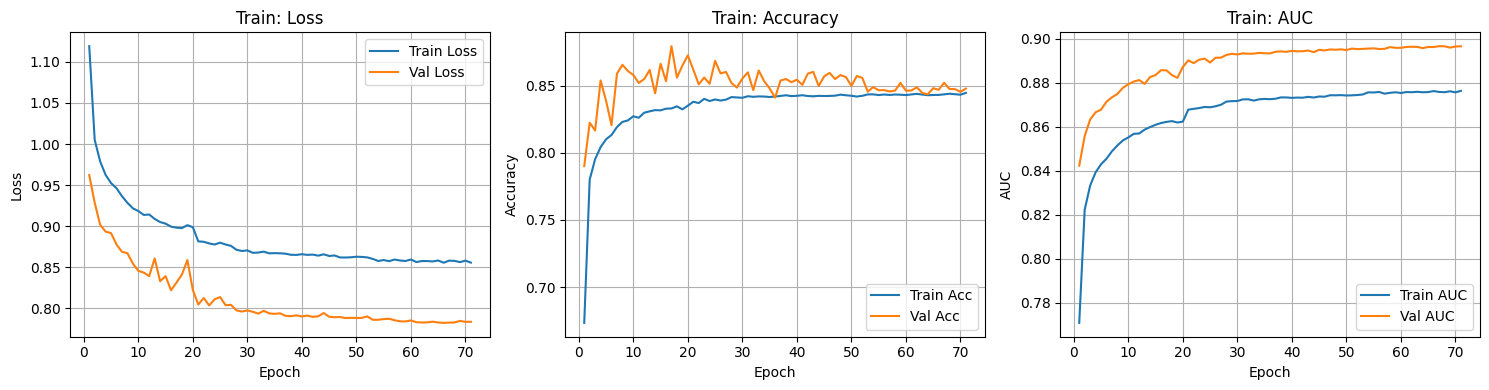

In [47]:
# ------ Графики после основного обучения ------
plot_training_history(history, title_prefix="Train: ")

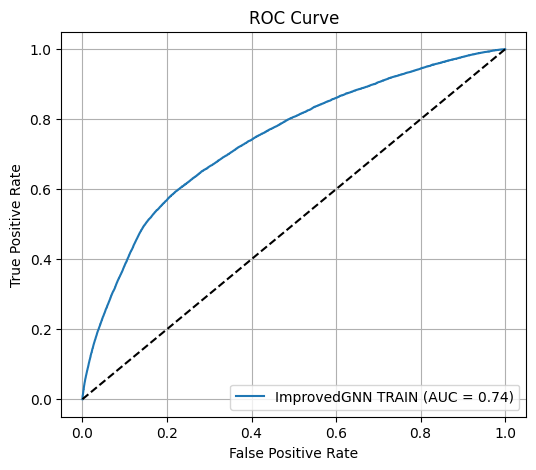

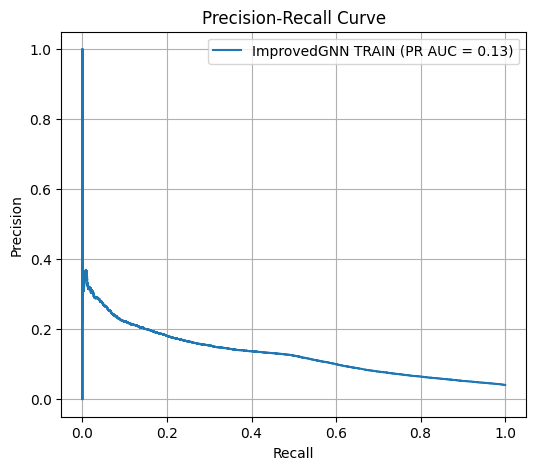

{'Accuracy': 0.7527730952266621,
 'F1': 0.16706118765007408,
 'AUC': np.float64(0.7414819827508254),
 'Precision': 0.09673316044294124,
 'Recall': 0.6120157215047726}

In [49]:
evaluate(model=model, loader=train_loader, name="ImprovedGNN TRAIN")

In [48]:
# === 6. Fine-tune/дообучение после рестарта (например, с новым lr или данными) ===

# Загружаем чекпоинт
checkpoint_path = '../data/model/best_gnn_checkpoint.pt'
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)

# Воссоздаем модель с теми же параметрами!
#input_dim = 8
#hidden_dim = 16
model_finetune = ImprovedGNN(input_dim=data.x.shape[1], hidden_dim=32).to(device)

pos_weight = torch.tensor([N_negative / N_positive], dtype=torch.float).to(device)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Новый оптимизатор, при желании меняем lr, но не weight_decay!
optimizer_finetune = torch.optim.AdamW(model_finetune.parameters(), lr=5e-4, weight_decay=5e-4)
scheduler_finetune = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_finetune, patience=3, factor=0.5)

model_finetune.load_state_dict(checkpoint['model_state_dict'])
optimizer_finetune.load_state_dict(checkpoint['optimizer_state_dict'])
if checkpoint['scheduler_state_dict'] is not None:
    scheduler_finetune.load_state_dict(checkpoint['scheduler_state_dict'])

# Определяем с какой эпохи продолжить (можно добавить +1)
start_epoch = checkpoint['epoch'] + 1
history_ft = checkpoint['history']

# Запускаем дообучение
model_finetune, history_ft, best_epoch_ft = fit_gnn(
    model_finetune,
    train_loader=train_loader,
    val_loader=train_loader,
    optimizer=optimizer_finetune,
    scheduler=scheduler_finetune,
    epochs=start_epoch+10,  # например, дообучаем еще 10 эпох
    device=device,
    grad_clip=1.0,
    early_stopping_rounds=5,
    save_best=True,
    save_path='best_gnn_checkpoint_finetune.pt'
)
print(f"Лучшая эпоха дообучения: {best_epoch_ft+1}")

Epoch 001/76 | Train Loss: 0.1821, Val Loss: 0.1340 | Acc: train 0.9602, val 0.9684 | AUC: train 0.7938, val 0.8411 | LR: 0.000125
 ** Best checkpoint saved to best_gnn_checkpoint_finetune.pt (epoch 1)
Epoch 002/76 | Train Loss: 0.1461, Val Loss: 0.1225 | Acc: train 0.9662, val 0.9692 | AUC: train 0.8177, val 0.8589 | LR: 0.000125
 ** Best checkpoint saved to best_gnn_checkpoint_finetune.pt (epoch 2)
Epoch 003/76 | Train Loss: 0.1389, Val Loss: 0.1175 | Acc: train 0.9667, val 0.9692 | AUC: train 0.8276, val 0.8656 | LR: 0.000125
 ** Best checkpoint saved to best_gnn_checkpoint_finetune.pt (epoch 3)
Epoch 004/76 | Train Loss: 0.1337, Val Loss: 0.1139 | Acc: train 0.9668, val 0.9693 | AUC: train 0.8338, val 0.8744 | LR: 0.000125
 ** Best checkpoint saved to best_gnn_checkpoint_finetune.pt (epoch 4)
Epoch 005/76 | Train Loss: 0.1304, Val Loss: 0.1108 | Acc: train 0.9669, val 0.9694 | AUC: train 0.8379, val 0.8826 | LR: 0.000125
 ** Best checkpoint saved to best_gnn_checkpoint_finetune.pt 

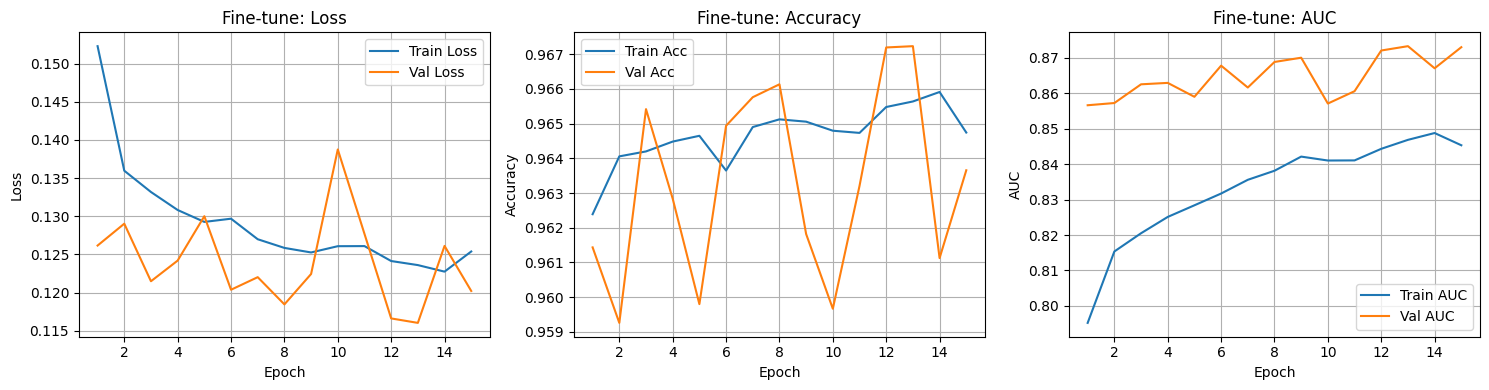

In [42]:
# ------ Графики после дообучения (fine-tune) ------
# Если дообучали — можно подгрузить history из чекпоинта для finetune либо использовать history_ft
plot_training_history(history_ft, title_prefix="Fine-tune: ")


In [ ]:
# Если хотите объединить кривые (например, обучение + дообучение)
def concat_histories(h1, h2):
    result = {}
    for k in h1:
        result[k] = h1[k] + h2[k]
    return result

# Пример:
# all_history = concat_histories(history, history_ft)
# plot_training_history(all_history, title_prefix="Train + Fine-tune: ")